In [ ]:
# Download Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")

print("Path to dataset files:", path)

# new dataset name
org_dir = 'videos_org'
org_path = path + '/' + org_dir
directory = 'wlasl_10'
reduced_path = path + '/' + directory
videos_path = path + '/videos'

!source activate video
!python utils/reorg.py {org_dir} 10
!mkdir -p {reduced_path}
!mv {org_path}/man    {reduced_path}
!mv {org_path}/woman  {reduced_path}
!mv {org_path}/who    {reduced_path}
!mv {org_path}/cousin {reduced_path}
!mv {org_path}/help   {reduced_path}
!mv {org_path}/deaf   {reduced_path}
!mv {org_path}/thin   {reduced_path}
!mv {org_path}/no     {reduced_path}
!mv {org_path}/leave  {reduced_path}
!mv {org_path}/soon   {reduced_path}


100%|██████████| 4.82G/4.82G [00:21<00:00, 239MB/s]

Extracting files...


Path to dataset files: /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5
/sfs/weka/scratch/tkg5kq/BIKE/utils/reorg.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word = row[1][0]
/sfs/weka/scratch/tkg5kq/BIKE/utils/reorg.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  instance_len = len(row[1][1])
/sfs/weka/scratch/tkg5kq/BIKE/utils/reorg.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  v

In [ ]:
!git clone https://github.com/whwu95/MVFNet.git
directory = 'wlasl_10'
resized_dir = path + '/resized_' + directory
frame_dir = path + '/frames_' + directory
!python MVFNet/data_process/video_resize.py {reduced_path} {resized_dir} --level 2 -se 256
!python MVFNet/data_process/video2image.py {resized_dir} {frame_dir} --level 2 --lib opencv --prefix image_%04d.jpg
!rm -rf MVFNet

Cloning into 'MVFNet'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 310 (delta 113), reused 273 (delta 87), pack-reused 0 (from 0)
Receiving objects: 100% (310/310), 20.42 MiB | 21.88 MiB/s, done.
Resolving deltas: 100% (113/113), done.
100%|█████████████████████████████████████████| 125/125 [00:06<00:00, 18.33it/s]


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")

print("Path to dataset files:", path)

/home/tkg5kq/.conda/envs/video/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5


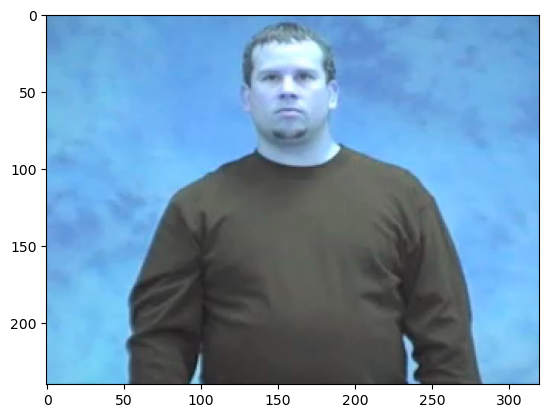

In [3]:
video_dir = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/videos/'
video = video_dir + '56811.mp4'


cap = cv2.VideoCapture(video)

while(cap.isOpened()):
    ret, frame = cap.read()
    # cv2.imshow('frame',frame)
    break

plt.figure()
# array = plt.imread(directory + IMAGE_FILES[0])
plt.imshow(frame)
# cap.release()
# cv2.destroyAllWindows()


In [3]:

import os
os.environ["GLOG_minloglevel"] ="5"
os.environ['OPENCV_LOG_LEVEL'] = 'ERROR'
import mediapipe as mp
debug = False

def mediapipe_to_numpy(landmark):
  np_arr = np.zeros(shape=(len(landmark), 3), dtype=float)
  for i, _landmark in enumerate(landmark):
    np_arr[i, 0] = _landmark.x
    np_arr[i, 1] = _landmark.y
    np_arr[i, 2] = _landmark.z
  return np_arr

def make_annotated_frame(mp_drawing, mp_drawing_styles, idx, results, image_width, image_height):
  for hand_landmarks in results.multi_hand_landmarks:
    np_arr = mediapipe_to_numpy(hand_landmarks.landmark)
    print('hand_landmarks:', hand_landmarks)
    print(
        f'Index finger tip coordinates: (',
        f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
        f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
    )
    print(type(hand_landmarks))
    print(len(hand_landmarks.landmark))
    print(len(mp_hands.HandLandmark))
    print(dir(hand_landmarks))
    print(np_arr.shape)
    # Create annotated image
    mp_drawing.draw_landmarks(
        annotated_image,
        hand_landmarks,
        mp_hands.HAND_CONNECTIONS,
        mp_drawing_styles.get_default_hand_landmarks_style(),
        mp_drawing_styles.get_default_hand_connections_style())
    cv2.imwrite(
        '/tmp/annotated_image' + str(idx) + '.png', cv2.flip(annotated_image, 1))

def get_hands(video):
  cap = cv2.VideoCapture(video)

  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles
  mp_hands = mp.solutions.hands

  
  with mp_hands.Hands(
      static_image_mode=True,
      max_num_hands=2,
      min_detection_confidence=0.5) as hands:
    idx = 0
    while(cap.isOpened()):
      ret, frame = cap.read()
      
      # Read an image, flip it around y-axis for correct handedness output (see
      # above).
      # frame = cv2.imread(directory + file)
      image = cv2.flip(frame, 1)
      # Convert the BGR image to RGB before processing.
      results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      # Print handedness and draw hand landmarks on the image.
      # print('Handedness:', results.multi_handedness)
      if results.multi_hand_landmarks:
        if debug:
          image_height, image_width, _ = image.shape
          annotated_image = image.copy()
          make_annotated_frame(mp_drawing, mp_drawing_styles, idx, results, image_width, image_height)

        for hand_world_landmarks in results.multi_hand_world_landmarks:
          print(dir(hand_world_landmarks))
          np_arr = mediapipe_to_numpy(hand_world_landmarks.landmark)
          if debug:
            mp_drawing.plot_landmarks(
              hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)
          print(np_arr)
          
        idx += 1
        if idx == 1:
          break

In [13]:
# For static images:
# directory = '/home/tkg5kq/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1/asl_dataset/a/'
import warnings
import logging

stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')

# Set logging level to ERROR
logging.basicConfig(level=logging.ERROR)

# Suppress all warnings
warnings.filterwarnings("ignore", category=Warning)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


video = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/videos/56811.mp4'
get_hands(video)
sys.stderr.close()
sys.stderr = stderr

I0000 00:00:1733286989.240451  988716 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733286989.269205  990614 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1733286989.289630  990568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733286989.304679  990601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


['ByteSize', 'Clear', 'ClearExtension', 'ClearField', 'CopyFrom', 'DESCRIPTOR', 'DiscardUnknownFields', 'Extensions', 'FindInitializationErrors', 'FromString', 'HasExtension', 'HasField', 'IsInitialized', 'ListFields', 'MergeFrom', 'MergeFromString', 'ParseFromString', 'RegisterExtension', 'SerializePartialToString', 'SerializeToString', 'SetInParent', 'UnknownFields', 'WhichOneof', '_CheckCalledFromGeneratedFile', '_ListFieldsItemKey', '_SetListener', '__class__', '__deepcopy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__unicode__']
[[ 1.02378596e-02  4.66298908e-02  6.45369068e-02]
 [-9.87816043e-03  1.99709050e-02  5.50761148e-02]
 [-1.70401987e-02  1.35402381e-03  4.29936722e-0

In [14]:
from datasets.video_attr import Video_dataset
from utils.Augmentation import get_augmentation
from dotmap import DotMap
import yaml

path = '/scratch/tkg5kq/BIKE/configs/wlasl/wlasl_k400_finetune.yaml'
# path = '/scratch/tkg5kq/BIKE/configs/k400/k400_train_video_attr_vitb-32-f8.yaml'
with open(path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = DotMap(config)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    cudnn.benchmark = True

transform_train = get_augmentation(True, config)
transform_val = get_augmentation(False, config)
print(config.data.attributes_train_path)
train_data = Video_dataset(
        config.data.train_root, config.data.train_list,
        config.data.label_list, num_segments=config.data.num_segments,
        modality=config.data.modality,
        image_tmpl=config.data.image_tmpl, random_shift=config.data.random_shift,
        transform=transform_train, dense_sample=config.data.dense,
        select_topk_attributes=config.data.select_topk_attributes,
        attributes_path=None,
        train_video=False,
        train_pose=True)

DotMap()
video number:112


In [8]:
print(train_data.video_list[0].label)
print(train_data.video_list[0].num_frames)
print(train_data.video_list[0].path)

0
105
/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/frames_wlasl_10/cousin/13630


In [9]:
item = train_data.__getitem__(0) #, debug=True)

I0000 00:00:1733263638.726330   59782 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733263638.759662   60190 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1733263638.778495   60146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733263638.793503   60172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733263638.834101   59782 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733263638.852933   60239 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1733263638.872902   60193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature

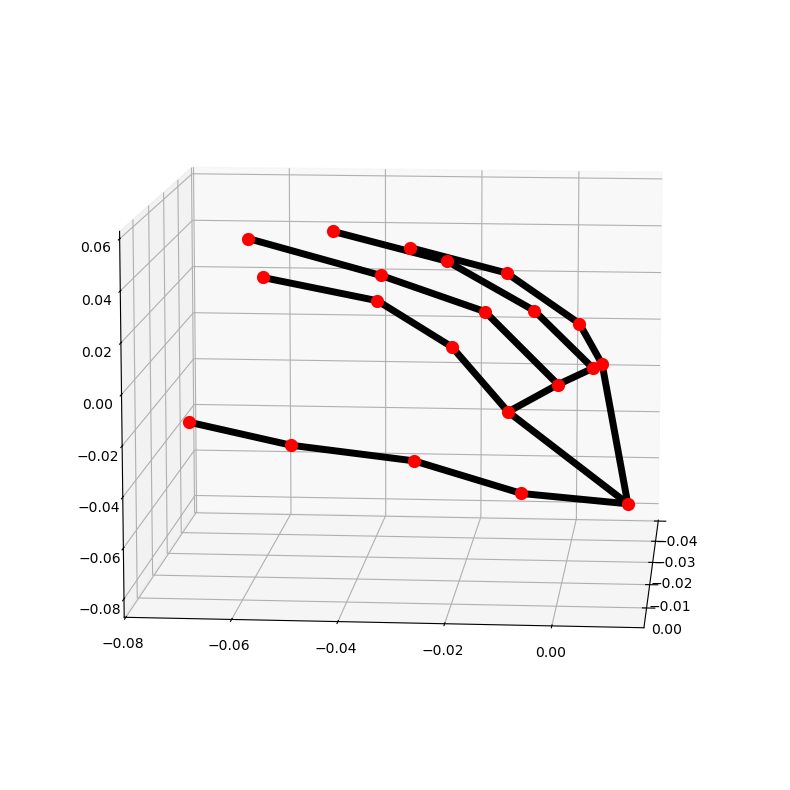

In [11]:
from mediapipe.framework.formats.landmark_pb2 import LandmarkList, Landmark

def numpy_to_mediapipe(np_arr):
    # Create a LandmarkList object
    landmark_list_list = []
    
    # Iterate through each row in the NumPy array
    for row in np_arr:
        landmark_list = LandmarkList()
        # Create a new Landmark for each set of coordinates
        for coor in row:
            landmark = Landmark()
            landmark.x = coor[0]
            landmark.y = coor[1]
            landmark.z = coor[2]
            # Append the Landmark to the LandmarkList
            landmark_list.landmark.append(landmark)
        landmark_list_list.append(landmark_list)

    return landmark_list_list

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
poses, labels = item
hand_world_landmarks = numpy_to_mediapipe(np.array(poses))
mp_drawing.plot_landmarks(hand_world_landmarks[7], mp_hands.HAND_CONNECTIONS, azimuth=5)

In [12]:

# train_sampler = torch.utils.data.distributed.DistributedSampler(train_data)                       
train_loader = DataLoader(train_data,
    batch_size=config.data.batch_size, drop_last=False)

In [13]:


    
for i, (pose, class_id) in enumerate(train_loader):
    print(pose.shape)
    pose = pose.to(device).reshape(-1, pose.shape[-1])
    print(pose.shape)
    break

I0000 00:00:1733263654.872031   59782 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733263654.905284   61065 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1733263654.920425   61039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733263654.930667   61045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733263654.985742   59782 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733263655.004140   61115 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1733263655.014401   61066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature

torch.Size([1, 16, 21, 3])
torch.Size([336, 3])
